# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

In [2]:
import sys
sys.path.append("../notebooks/")

# Imports Section 

In [3]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [28]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Zika Specific Variables 

In [7]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [4]:
clades_to_plot = None

In [68]:
domain = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c9', 'c10', "unassigned"]
range_ = ['#4f61ff', '#71cfd4', '#97e59f', '#c7f071', '#f8e957', '#ffcc49', '#ff903e', '#ff3b2d', '#58a3fd', '#4f92e4', '#000000']

# Reading in all the data from the scripts

In [6]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/zika-nextstrain'

In [69]:
node_df = pd.read_csv(node_df, sep="\t")
#node_df = pd.read_csv("results/table.tsv", sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)
node_df = node_df.take(node_df["clade_membership"].dropna().index.values.tolist())

In [70]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [71]:
node_df['clade_membership'].value_counts()

c4            139
c2            123
c3            111
c5            103
c7             45
c6             43
c1             43
c9             35
c10            29
unassigned      3
Name: clade_membership, dtype: int64

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [72]:
principalDf = pd.read_csv(pca_df, index_col=0)
#principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [73]:
explained_variance_df = pd.read_csv(explained_variance_pca)
#explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

,explained variance,principal components
0,0.3303,0
1,0.0668,1
2,0.0582,2
3,0.0410,3
4,0.0278,4
5,0.0181,5
6,0.0137,6
7,0.0127,7
8,0.0100,8
9,0.0085,9


In [75]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')
plt.savefig(snakemake.output.Explained_variance_PCA)

In [76]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [77]:
merged_pca_df.head()

,strain,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca_label,date,y,clade_membership,clade_membership_color
0,FrenchPolynesia2014_060114_016,-0.997941,-0.175648,-0.003561,0.365233,1.466314,0.385359,0.106724,-0.499462,-0.059383,0.102441,7,2014.02,153,c1,c1
1,1_0049_PF,-1.198016,-0.181179,0.006347,0.365003,1.150645,0.555289,0.123734,-0.541795,-0.060750,0.063962,7,2013.98,159,c1,c1
2,1_0030_PF,-0.799273,-0.188163,-0.026013,0.406214,1.691945,0.217905,0.095011,-0.474991,-0.058493,0.122324,-1,2013.90,148,c1,c1
3,1_0035_PF,-0.796212,-0.176426,-0.004482,0.416134,1.674878,0.219091,-0.004162,-0.479464,-0.052152,0.129361,-1,2014.08,149,c1,c1
4,1_0087_PF,-0.795955,-0.176493,-0.005463,0.409790,1.671313,0.223653,0.093968,-0.450863,-0.052804,0.124998,-1,2013.99,151,c1,c1


In [78]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [79]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [46]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

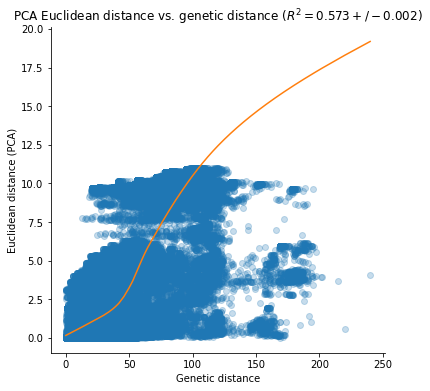

In [47]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

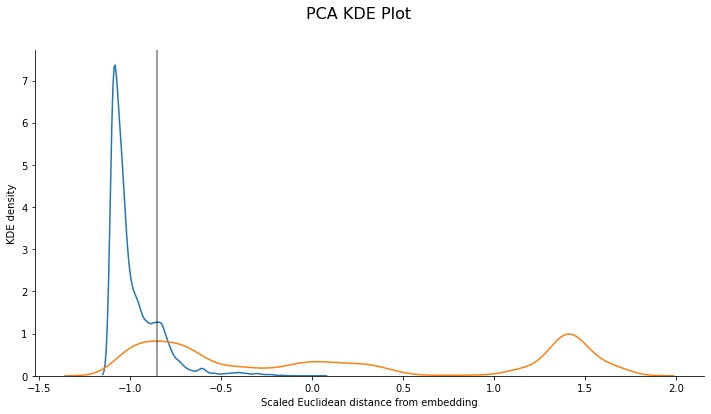

In [48]:
PCA_KDE_df = pd.read_csv(KDE_pca,index_col=0)
PCA_KDE_metadata_df = pd.read_csv(KDE_pca_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [41]:
#MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)
MDS_df = pd.read_csv(mds_df,index_col=0)

In [42]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [43]:
merged_mds_df

,strain,mds1,mds2,mds3,mds4,mds5,mds6,mds7,mds8,mds9,mds10,mds_label,date,y,clade_membership,clade_membership_color
0,FrenchPolynesia2014_060114_016,4.129054,13.112623,1.741848,-2.724872,5.655200,-1.330113,-2.192388,-2.466294,-0.770108,3.271515,-1,2014.02,157,c1,c1
1,1_0049_PF,3.582383,7.384704,-0.112876,-2.196018,4.304568,-1.436197,-4.642009,1.189096,-2.221286,4.956264,6,2014.00,159,c1,c1
2,1_0030_PF,1.261029,11.225181,4.996538,-0.675158,4.631858,-1.165978,-4.999114,-2.297133,1.101342,6.690295,-1,2013.85,129,c1,c1
3,1_0035_PF,2.211633,10.868029,7.278493,-2.109287,6.843734,-1.345265,-4.202179,-2.735879,-1.369798,6.463743,-1,2014.05,130,c1,c1
4,1_0087_PF,1.969932,9.287307,4.187647,-1.375823,4.755413,-1.549778,-2.671140,-1.947688,-0.220622,4.789161,-1,2013.96,133,c1,c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,MEX/2016/mex45,-3.423036,-0.159996,0.160193,-1.105841,-0.775239,-1.809334,-0.369571,0.405363,0.161886,-1.995334,6,2016.50,555,c4,c4
664,Bahia15,0.511999,0.660384,-0.046164,-0.123839,0.212477,0.603482,0.183375,0.207389,-0.041407,1.148536,6,2016.00,180,c3,c3
665,NIC/5847_12B1/2016,-2.357302,-0.819468,-1.082556,-0.639712,-0.904837,-2.995984,-2.677207,0.247250,-1.076854,-2.555581,6,2016.10,648,c4,c4
666,USA/2016/FLUR005,-1.447511,0.677582,1.426415,-3.560543,-1.804872,7.091327,4.249922,8.942806,-1.451194,1.554214,6,2016.58,422,c5,c5


In [44]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership_color:N', domain, range_)
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color', domain, range_)
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color', domain, range_)
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [45]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [54]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

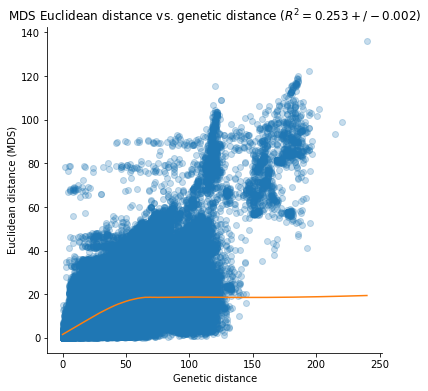

In [55]:
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

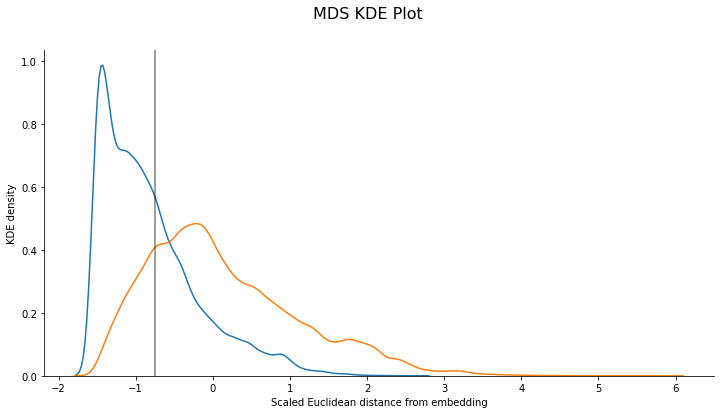

In [56]:
MDS_KDE_df = pd.read_csv(KDE_mds,index_col=0)
MDS_KDE_metadata_df = pd.read_csv(KDE_mds_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [35]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color", "tsne_x", "tsne_y"]]

In [37]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["clade_membership:N","strain:N"],
    domain,
    range_
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [ ]:
list_of_chart = linking_tree_with_plots_clickable(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ['t-sne_label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

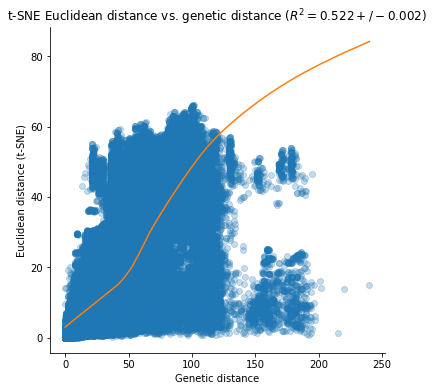

In [62]:
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")

ax.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

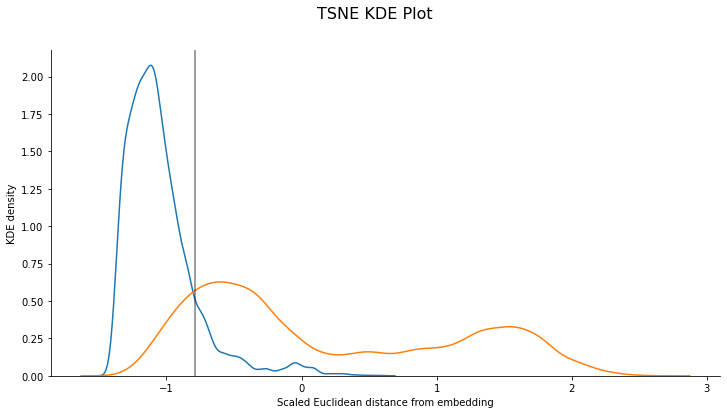

In [63]:
TSNE_KDE_df = pd.read_csv(KDE_tsne,index_col=0)
TSNE_KDE_metadata_df = pd.read_csv(KDE_tsne_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [64]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("results/embed_umap.csv",index_col=0)

In [38]:
UMAP_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color", "umap_x", "umap_y", "umap_label"]]

In [40]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership:N',
    ["clade_membership:N","strain:N"],
    domain,
    range_
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

# HDBSCAN Output

In [ ]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'umap_label:N',
    ['umap_label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

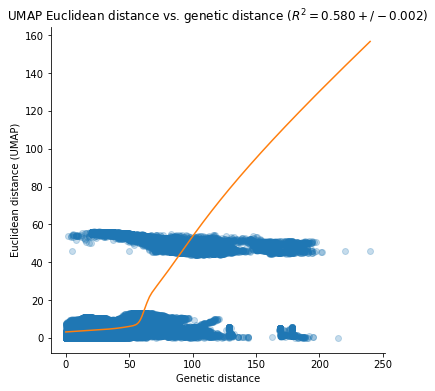

In [68]:
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")

ax.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")
sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

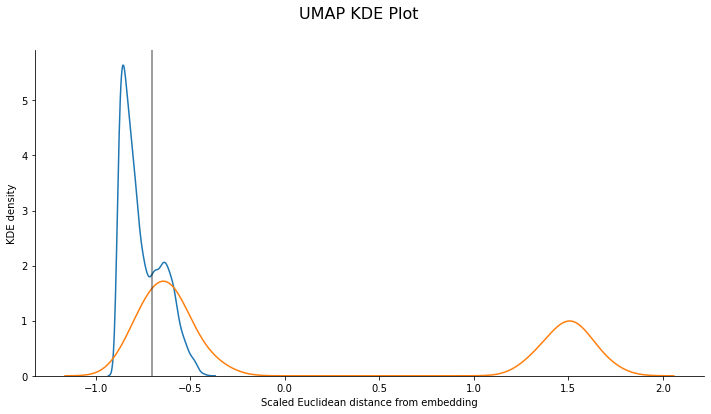

In [69]:
UMAP_KDE_df = pd.read_csv(KDE_umap,index_col=0)
UMAP_KDE_metadata_df = pd.read_csv(KDE_umap_metadata, index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [58]:
merged_df = node_df.merge(principalDf[["pca3", "pca4"]], on="strain")

In [62]:
data = linking_tree_with_plots_brush(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'pca3', 'pca4','umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'PCA3 (Expected Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
    'PCA4 (Expected Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")", 'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain','clade_membership'],
    domain,
    range_
)

In [63]:
PCAMDS = data[3]|data[4]|data[1]
TSNEUMAP = data[2]|data[5]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save(snakemake.output.fullChart)
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

alt.HConcatChart(...)

In [52]:
fullChart

alt.HConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

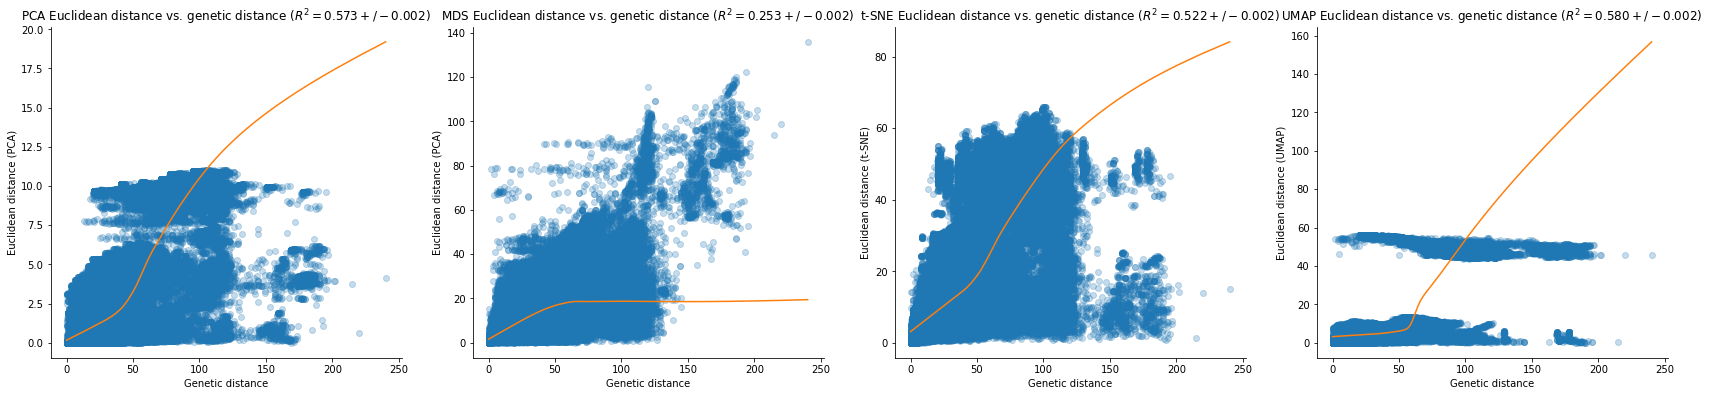

In [74]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot)

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [75]:
Genetic_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_genetic.csv",index_col=0)
Genetic_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_genetic_metadata.csv", index_col=0)

In [76]:
import matplotlib.gridspec as gridspec

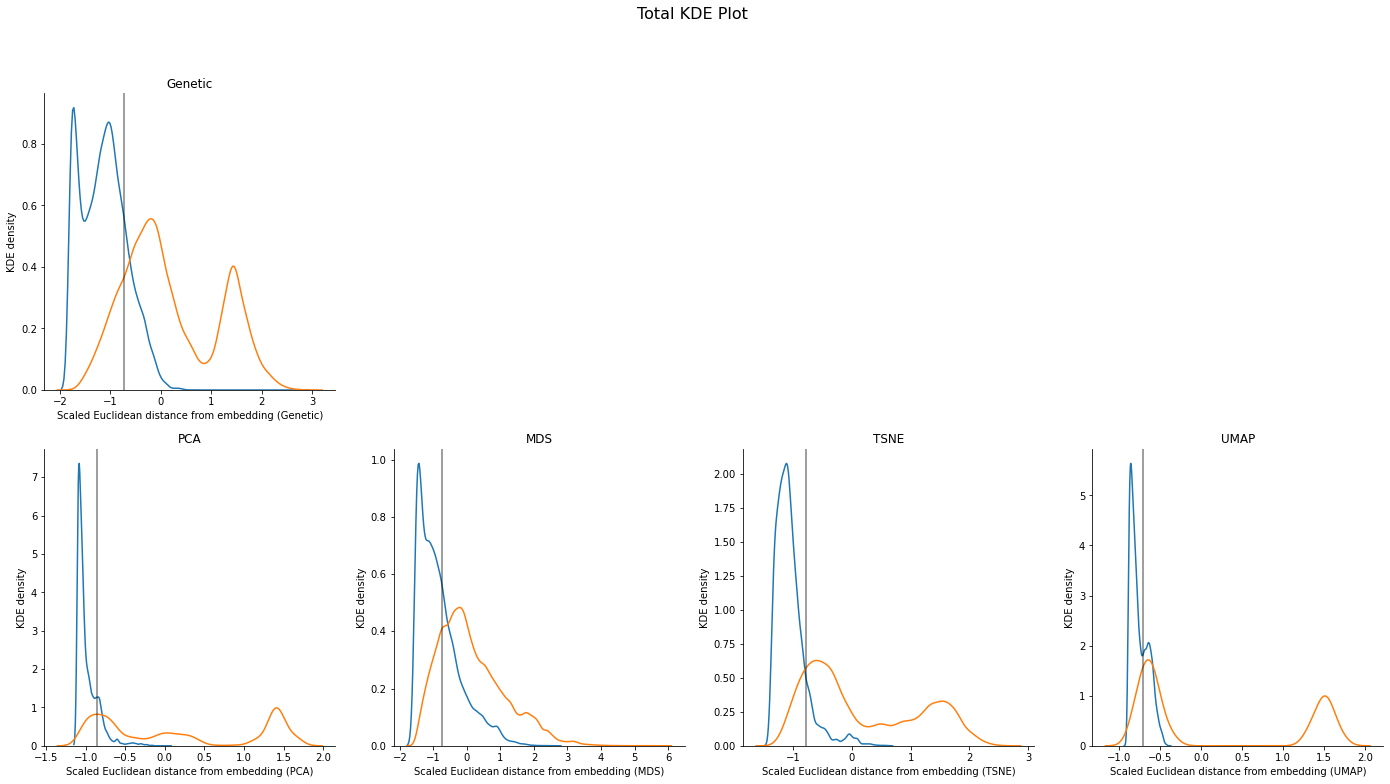

In [77]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(30, 15), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax4.legend(frameon=False)
ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.legend(frameon=False)
ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig(snakemake.output.KDE_density, dpi=600)

# Supplemental Figures

In [55]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]
chart.save(snakemake.output.MDS_Supplement)

alt.HConcatChart(...)

In [56]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

chart.save(snakemake.output.PCA_Supplement)

alt.HConcatChart(...)